In [1]:
import numpy as np
import csv
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import os

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsolutePercentageError
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

def calc_avg(lst):
    total = 0
    for element in lst:
        total += element
    if len(lst) < 1:
        return 0
    else:
        return total/len(lst)

def read_data(filename):
    nprocs = []
    runtime = []
    total_jobs = []
    submit_time = []
    
    core_count = []
    r = []
    
    with open(filename) as file:
        tsv_file = csv.reader(file, delimiter="\t")
        field_count = 0
        while int(field_count) < 20:
            field_count = int(len(next(tsv_file)))

        last_time = -1
        last_hour = -1
        job_count = 0
        last_submitted = -1
        i = 0
        for line in tsv_file:
            if (float(line.__getitem__(3)) > -0.5) and (float(line.__getitem__(4)) > -0.5):
                submitted = int(line.__getitem__(1))
                dt = datetime.datetime.fromtimestamp(submitted)
                time_hour = dt.hour

                if last_hour == -1:
                    last_hour = time_hour
                    last_time = dt
                
                if last_hour != time_hour:
                    runtime.append(calc_avg(r))
                    nprocs.append(calc_avg(core_count))
                    total_jobs.append(job_count)
                    submit_time.append(dt.replace(minute=0, second=0, microsecond=0))
                    last_time = dt
                    job_count = 0
                    core_count.clear
                    r.clear
                    last_submitted = -1
                
                core_count.append(float(line.__getitem__(4))) # number of allocated processors
                r.append(float(line.__getitem__(3))) # runtime of the job
                job_count += 1
                last_submitted = submitted
                last_hour = time_hour
    return submit_time, runtime, nprocs, total_jobs

def read_dataframe():
    submit_time, runtime, nprocs, total_jobs, total = read_data('anon_jobs_LCG.gwf') #SharcNet
    df = pd.DataFrame(list(zip(submit_time, runtime, nprocs, total_jobs)), columns=['ds', 'RunTime', 'NProcs', 'TotalJobs'])
    df.to_pickle('job_traces_lcg')
    return df

In [21]:
tf.random.set_seed(7)
#dataframe = read_dataframe()
dataframe = pd.read_pickle('anon_jobs_sharc')
dataframe.head()

,RunTime,NProcs,TotalJobs
ds,,,
2005-12-21 03:00:00,13.600000,5.400000,5
2006-01-24 17:00:00,77.000000,19.500000,9
2006-01-24 18:00:00,148.625000,27.062500,2
2006-01-24 19:00:00,119.105263,48.947368,22
2006-01-24 20:00:00,171.384615,73.948718,1


In [22]:
tf.random.set_seed(7)
print(tf.test.gpu_device_name())

/device:GPU:0


In [23]:
df = dataframe[['TotalJobs']]
df.head()

,TotalJobs
ds,
2005-12-21 03:00:00,5
2006-01-24 17:00:00,9
2006-01-24 18:00:00,2
2006-01-24 19:00:00,22
2006-01-24 20:00:00,1


In [24]:
windows_size = 1

def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [a for a in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size]
        y.append(label[0])
    return np.array(X), np.array(y)

X, Y = df_to_X_y(df,windows_size)
X.shape, Y.shape

((7075, 1, 1), (7075,))

In [25]:
train_size = int(len(df)*0.75)
val_size = train_size + int(train_size * 0.2)
train_X = X[:train_size]
train_Y = Y[:train_size]
val_X = X[train_size:val_size]
val_Y = Y[train_size:val_size]
test_X = X[val_size:]
test_Y = Y[val_size:]
len(train_X), len(val_X), len(test_X)

(5307, 1061, 707)

In [26]:
tf.random.set_seed(7)
model1 = Sequential()
model1.add(InputLayer((windows_size,1)))
model1.add(LSTM(128))
model1.add(Dense(64, 'relu'))
model1.add(Dense(32, 'relu'))
model1.add(Dense(1, 'linear'))
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 128)               66560     
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 76,929
Trainable params: 76,929
Non-trainable params: 0
_________________________________________________________________


In [27]:
cp1 = ModelCheckpoint('model-sharc/', save_best_only=True)
model1.compile(loss='mean_squared_error', optimizer='adam', metrics=[MeanAbsolutePercentageError()])

In [28]:
model1.fit(train_X, train_Y, validation_data=(val_X, val_Y), epochs=100, callbacks=[cp1])

Epoch 1/100
164/166 [============================>.] - ETA: 0s - loss: 482460.6875 - mean_absolute_percentage_error: 547.4012

INFO:tensorflow:Assets written to: model-sharc\assets


INFO:tensorflow:Assets written to: model-sharc\assets


166/166 [==============================] - 6s 29ms/step - loss: 477698.8125 - mean_absolute_percentage_error: 553.5938 - val_loss: 582163.6875 - val_mean_absolute_percentage_error: 775.1568
Epoch 2/100
162/166 [============================>.] - ETA: 0s - loss: 470566.5625 - mean_absolute_percentage_error: 1104.0079

INFO:tensorflow:Assets written to: model-sharc\assets


INFO:tensorflow:Assets written to: model-sharc\assets


166/166 [==============================] - 4s 26ms/step - loss: 463497.4688 - mean_absolute_percentage_error: 1107.7892 - val_loss: 565695.0625 - val_mean_absolute_percentage_error: 961.7690
Epoch 3/100
166/166 [==============================] - 1s 7ms/step - loss: 462775.6562 - mean_absolute_percentage_error: 1241.0521 - val_loss: 572847.1250 - val_mean_absolute_percentage_error: 860.4617
Epoch 4/100
166/166 [==============================] - 1s 7ms/step - loss: 460966.7500 - mean_absolute_percentage_error: 1301.5601 - val_loss: 567734.5000 - val_mean_absolute_percentage_error: 889.6387
Epoch 5/100
159/166 [===========================>..] - ETA: 0s - loss: 377748.3750 - mean_absolute_percentage_error: 1385.5260

INFO:tensorflow:Assets written to: model-sharc\assets


INFO:tensorflow:Assets written to: model-sharc\assets


166/166 [==============================] - 4s 23ms/step - loss: 459463.5000 - mean_absolute_percentage_error: 1397.0894 - val_loss: 559121.6250 - val_mean_absolute_percentage_error: 1115.4320
Epoch 6/100
166/166 [==============================] - 1s 5ms/step - loss: 459373.6562 - mean_absolute_percentage_error: 1455.0093 - val_loss: 562310.1250 - val_mean_absolute_percentage_error: 970.2903
Epoch 7/100
166/166 [==============================] - 1s 5ms/step - loss: 458972.0625 - mean_absolute_percentage_error: 1380.7058 - val_loss: 561525.7500 - val_mean_absolute_percentage_error: 1063.7563
Epoch 8/100
166/166 [==============================] - 1s 5ms/step - loss: 458096.0938 - mean_absolute_percentage_error: 1474.2991 - val_loss: 582987.9375 - val_mean_absolute_percentage_error: 781.2241
Epoch 9/100
166/166 [==============================] - 1s 5ms/step - loss: 459281.9375 - mean_absolute_percentage_error: 1460.8914 - val_loss: 569967.9375 - val_mean_absolute_percentage_error: 800.6089

INFO:tensorflow:Assets written to: model-sharc\assets


INFO:tensorflow:Assets written to: model-sharc\assets


166/166 [==============================] - 4s 24ms/step - loss: 457862.2500 - mean_absolute_percentage_error: 1369.5637 - val_loss: 559080.5000 - val_mean_absolute_percentage_error: 961.1467
Epoch 63/100
166/166 [==============================] - 1s 6ms/step - loss: 458601.2188 - mean_absolute_percentage_error: 1486.0991 - val_loss: 563501.2500 - val_mean_absolute_percentage_error: 954.1638
Epoch 64/100
166/166 [==============================] - 1s 6ms/step - loss: 458025.7812 - mean_absolute_percentage_error: 1429.8744 - val_loss: 565041.6875 - val_mean_absolute_percentage_error: 897.3122
Epoch 65/100
166/166 [==============================] - 1s 6ms/step - loss: 457774.9688 - mean_absolute_percentage_error: 1456.9272 - val_loss: 562834.0625 - val_mean_absolute_percentage_error: 876.6117
Epoch 66/100
166/166 [==============================] - 1s 6ms/step - loss: 458161.0312 - mean_absolute_percentage_error: 1404.7534 - val_loss: 565631.5625 - val_mean_absolute_percentage_error: 931.63

INFO:tensorflow:Assets written to: model-sharc\assets


INFO:tensorflow:Assets written to: model-sharc\assets


166/166 [==============================] - 4s 24ms/step - loss: 457635.5312 - mean_absolute_percentage_error: 1441.3228 - val_loss: 558219.2500 - val_mean_absolute_percentage_error: 1161.4226
Epoch 68/100
166/166 [==============================] - 1s 6ms/step - loss: 458236.1562 - mean_absolute_percentage_error: 1339.9316 - val_loss: 560954.1250 - val_mean_absolute_percentage_error: 992.1778
Epoch 69/100
166/166 [==============================] - 1s 6ms/step - loss: 458788.9375 - mean_absolute_percentage_error: 1491.0669 - val_loss: 574757.6250 - val_mean_absolute_percentage_error: 856.7512
Epoch 70/100
166/166 [==============================] - 1s 6ms/step - loss: 458571.9375 - mean_absolute_percentage_error: 1269.5159 - val_loss: 563088.3125 - val_mean_absolute_percentage_error: 1013.1823
Epoch 71/100
166/166 [==============================] - 1s 6ms/step - loss: 458180.3750 - mean_absolute_percentage_error: 1580.1555 - val_loss: 563513.8750 - val_mean_absolute_percentage_error: 896.

INFO:tensorflow:Assets written to: model-sharc\assets


INFO:tensorflow:Assets written to: model-sharc\assets


166/166 [==============================] - 4s 23ms/step - loss: 457105.8125 - mean_absolute_percentage_error: 1502.3871 - val_loss: 556097.1875 - val_mean_absolute_percentage_error: 1069.4679
Epoch 77/100
166/166 [==============================] - 1s 6ms/step - loss: 458212.0312 - mean_absolute_percentage_error: 1392.6682 - val_loss: 567544.1875 - val_mean_absolute_percentage_error: 880.1776
Epoch 78/100
166/166 [==============================] - 1s 6ms/step - loss: 461146.9375 - mean_absolute_percentage_error: 1496.9105 - val_loss: 573315.6250 - val_mean_absolute_percentage_error: 950.2086
Epoch 79/100
166/166 [==============================] - 1s 6ms/step - loss: 461259.1250 - mean_absolute_percentage_error: 1352.4340 - val_loss: 566811.0000 - val_mean_absolute_percentage_error: 1000.1773
Epoch 80/100
166/166 [==============================] - 1s 6ms/step - loss: 459939.2812 - mean_absolute_percentage_error: 1505.2802 - val_loss: 564320.4375 - val_mean_absolute_percentage_error: 985.

In [29]:
from tensorflow.keras.models import load_model
model1 = load_model('model-sharc/')

In [30]:
steps = 24

train_predictions = model1.predict(test_X).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':test_Y})
train_results[-steps:]

23/23 [==============================] - 0s 4ms/step


,Train Predictions,Actuals
683,106.896721,18
684,88.131409,2
685,88.599319,2
686,88.599319,5
687,111.358398,15
688,77.556480,36
689,150.654007,17
690,83.301582,38
691,152.985931,17
692,83.301582,34


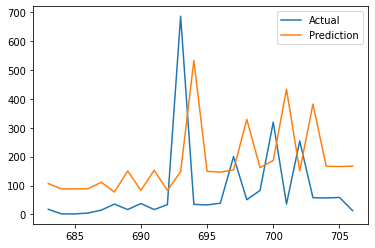

In [31]:

plt.plot(train_results['Actuals'][-steps:], label="Actual")
plt.plot(train_results['Train Predictions'][-steps:], label="Prediction")
plt.legend()

In [32]:
"mape", mean_absolute_percentage_error(train_results['Actuals'][-steps:], train_results['Train Predictions'][-steps:])

('mape', 8.125171471227278)